### Importing Libraries and dataset Images

In [ ]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import pathlib
import datetime
import time

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir='/content/drive/MyDrive/NTU/CE4042/classified_age_images'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/NTU/CE4042/classified_age_images')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

12653

### Prepare Train and Validation data set

In [ ]:
batch_size = 32
img_height = 256
img_width = 256
#split data into train and validation dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12653 files belonging to 7 classes.
Using 10123 files for training.
Found 12653 files belonging to 7 classes.
Using 2530 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['age_0_3', 'age_15_23', 'age_25_32', 'age_34_54', 'age_4_6', 'age_55_100', 'age_8_13']


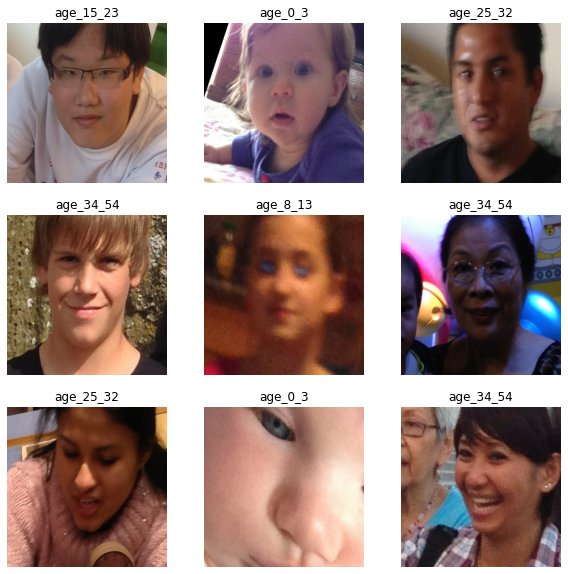

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#normalizing the data to achieve standardization
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


### Inception v3

In [ ]:
#retieving the inception_v3 model from tensorflowhub
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor_model = inception_v3

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(256, 256, 3),
    trainable=False)
#other models that we experimented with
#inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
#feature_extractor_model = inception_v3

#inception_resnet_v2 = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5"
#feature_extractor_model = inception_resnet_v2

#efficientnet_b7 = "https://tfhub.dev/tensorflow/efficientnet/b7/classification/1"
#feature_extractor_model = efficientnet_b7

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 21,817,127
Trainable params: 14,343
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)
#Defining early stopping
def early_stop_callback(name):
  return [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]

#Callback to restore best model weights 
checkpoint_filepath = './best_weights_file'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
NUM_EPOCHS = 50
#Fitting the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=32,
                    epochs=NUM_EPOCHS,
                    callbacks=[early_stop_callback("name"), model_checkpoint_callback])

Epoch 1/50
317/317 [==============================] - ETA: 0s - loss: 1.3531 - acc: 0.4777INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 954s 3s/step - loss: 1.3531 - acc: 0.4777 - val_loss: 1.2246 - val_acc: 0.5126
Epoch 2/50
316/317 [============================>.] - ETA: 0s - loss: 1.1791 - acc: 0.5486INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 32s 102ms/step - loss: 1.1791 - acc: 0.5487 - val_loss: 1.1870 - val_acc: 0.5411
Epoch 3/50
316/317 [============================>.] - ETA: 0s - loss: 1.1127 - acc: 0.5802INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 32s 102ms/step - loss: 1.1127 - acc: 0.5804 - val_loss: 1.1724 - val_acc: 0.5518
Epoch 4/50
316/317 [============================>.] - ETA: 0s - loss: 1.0666 - acc: 0.6000INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 32s 102ms/step - loss: 1.0666 - acc: 0.6001 - val_loss: 1.1665 - val_acc: 0.5593
Epoch 5/50
316/317 [============================>.] - ETA: 0s - loss: 1.0310 - acc: 0.6164INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 32s 102ms/step - loss: 1.0310 - acc: 0.6165 - val_loss: 1.1653 - val_acc: 0.5597
Epoch 6/50
317/317 [==============================] - 22s 70ms/step - loss: 1.0019 - acc: 0.6303 - val_loss: 1.1670 - val_acc: 0.5553
Epoch 7/50
317/317 [==============================] - 22s 70ms/step - loss: 0.9772 - acc: 0.6409 - val_loss: 1.1707 - val_acc: 0.5534
Epoch 8/50
317/317 [==============================] - 22s 71ms/step - loss: 0.9557 - acc: 0.6478 - val_loss: 1.1757 - val_acc: 0.5526
Epoch 9/50
317/317 [==============================] - 22s 70ms/step - loss: 0.9366 - acc: 0.6545 - val_loss: 1.1816 - val_acc: 0.5597
Epoch 10/50
317/317 [==============================] - 22s 70ms/step - loss: 0.9193 - acc: 0.6613 - val_loss: 1.1880 - val_acc: 0.5565
Epoch 11/50
317/317 [==============================] - 22s 70ms/step - loss: 0.9035 - acc: 0.6661 - val_loss: 1.1946 - val_acc: 0.5605
Epoch 12/50
317/317 [==============================] - 22s 71ms/step -

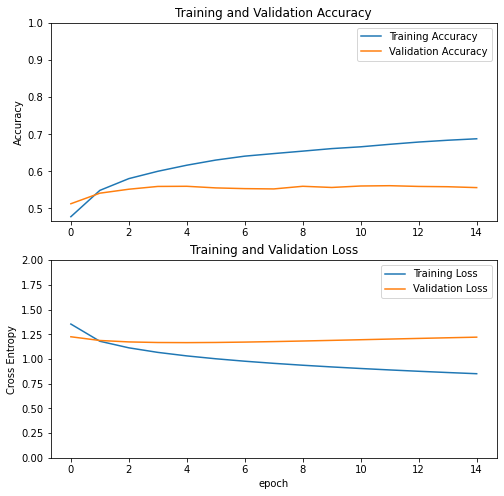

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']
#plotting the accuracy and the loss 
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Age Predictions

In [ ]:
class_names

['age_0_3',
 'age_15_23',
 'age_25_32',
 'age_34_54',
 'age_4_6',
 'age_55_100',
 'age_8_13']

In [ ]:
#predicting the age of the images
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_id
predicted_label_batch=[]
for i in predicted_id.numpy():
    if(i==0):
        predicted_label_batch.append("age_0_3")
    elif(i==1):
        predicted_label_batch.append("age_15_23")
    elif(i==2):
        predicted_label_batch.append("age_25_32")  
    elif(i==3):
        predicted_label_batch.append("age_34_54")
    elif(i==4):
        predicted_label_batch.append("age_4_6") 
    elif(i==5):
        predicted_label_batch.append("age_55_100")
    elif(i==6):
        predicted_label_batch.append("age_8_13")     
print(predicted_label_batch)

['age_25_32', 'age_15_23', 'age_4_6', 'age_4_6', 'age_25_32', 'age_34_54', 'age_15_23', 'age_4_6', 'age_25_32', 'age_34_54', 'age_0_3', 'age_0_3', 'age_25_32', 'age_25_32', 'age_0_3', 'age_25_32', 'age_15_23', 'age_4_6', 'age_25_32', 'age_0_3', 'age_25_32', 'age_25_32', 'age_25_32', 'age_25_32', 'age_4_6', 'age_25_32', 'age_25_32', 'age_34_54', 'age_0_3', 'age_25_32', 'age_0_3', 'age_15_23']


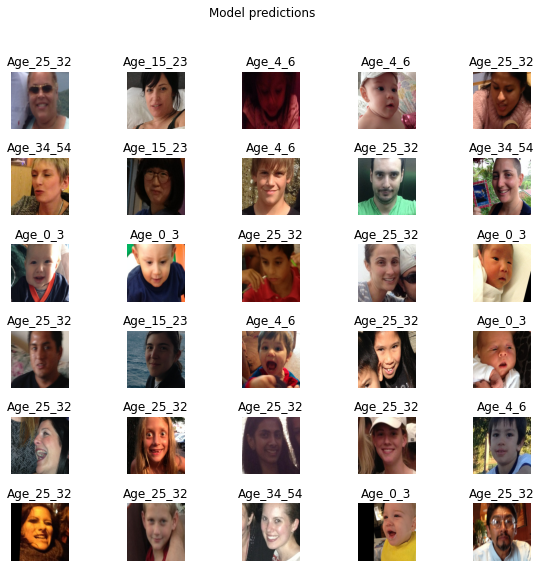

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [ ]:
t = time.time()
#saving the model to be used later
export_path = "/content/drive/MyDrive/Colab Notebooks/{}".format(int(t))
model.save(export_path)

export_path
#/content/drive/MyDrive/Colab Notebooks/1636790787

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/1636790787/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/1636790787/assets


'/content/drive/MyDrive/Colab Notebooks/1636790787'